<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/python/area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Az egyszerű algoritmustól az osztályokig


Ebben az oktatóanyagban zárt sokszög területének koordinátákból történő kiszámítását oldjuk meg többféleképpen.


## A probléma

Adott egy zárt sokszög töréspontjainak koordinátáival. Az idom területét az egyes oldalakhoz tartozó trapézok területének összegzésével számítjuk ki.

$T = \frac {\sum {(x_{i+1} - x_i) \cdot (y_{i+1} + y_i)}} {2}$

A fenti képletben az utolsó pont esetén (i = n) az i+1 az első pontra vonatkozik.

A töréspontok koordinátáit tároljuk egy összetett listában. Az egyes pontok koordinátáit tegyük egy két elemű listába és ezekből alkossunk egy listát a zárt idomhoz. A kezdőpont koordinátáját nem kell a lista végén újra megadni. Az alábbi egy háromszög leírása.

In [3]:
coords = [[1, 1], [3, 1], [2, 2]]
print(coords)
print(coords[0])    # nullától indul az indexelés!

[[1, 1], [3, 1], [2, 2]]
[1, 1]


A fenti egyszerű alakzat és a trapézok ábrázolása a képlet értelmezéséhez. Figyelem a trapézok területe a képletben előjeles szám!

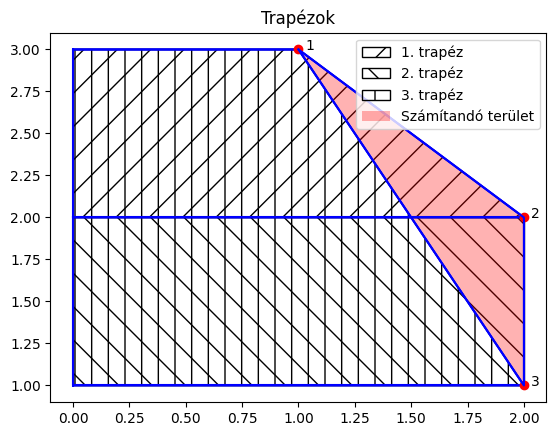

In [66]:
import matplotlib.pyplot as plt
x = [1, 2, 2, 1]    # a kezdőpontot a lista végére is betettük
y = [3, 2, 1, 3]
# a trapézok
h = ['/', '\\', '|']    # sraffozási stílusok
for i in range(len(x)-1):
    # trapézok kitöltése
    plt.fill([0, x[i], x[i+1], 0, 0], [y[i], y[i], y[i+1], y[i+1], y[i]], fill=False, hatch=h[i], label=f"{i+1}. trapéz")
    # trapéz körvonalak
    plt.plot([0, x[i], x[i+1], 0, 0], [y[i], y[i], y[i+1], y[i+1], y[i]], '-b')
plt.plot(x[:-1], y[:-1], 'ro')    # a töréspontok
for i in range(len(x)-1):
    # pontszám feliratok
    plt.annotate(i+1, (x[i]+0.03, y[i]))
plt.fill(x[:-1], y[:-1], 'r', fill=True, alpha=0.3, label="Számítandó terület")    # számítandó terület
plt.plot(x, y, '-b')          # az oldalak
plt.title('Trapézok')
plt.legend(loc='upper right')

## Első változat

A trapéz területeket számítsuk ki egyesével egy ciklusban és a részösszegeket egy változóban összegezzük (area).

In [4]:
area = 0.0
for i in range(len(coords)):
        j = (i + 1) % len(coords)
        area += (coords[j][0] + coords[i][0]) * (coords[j][1] - coords[i][1])
area /= 2.0
print(abs(area))

1.0


A len függvény a lista hosszát adja vissza (azaz a töréspontok számát). A range(n) függvényhívás a egész számok sorozatát adja vissza nullától n-1-ig. A % operátor az osztási maradékot adja, ezzel állítjuk elő, hogy az utosó pont után az első pontot használja a program. A listák indexelése nullától indul (az első elem indexe nulla). A coords[i] egy pont koordinátáit jelenti (két elemű lista), a coords[i][0] az i-edik pont első koordinátáját jelenti. Az így számított terület negatív is lehet, körüljárási iránytól függően, ezért használjuk az abs (abszolútérték) függvényt.

## Második változat

Amennyiben többször szeretnénk megismételni a területszámítást különböző zárt sokszögekre, akkor célszerűbb a kódot egy függvénybe tenni.

In [6]:
def area(coords):
        """ calculate area of a polygon

                :param coords: vertexes of polygon e.g. [[1, 1], [3, 1], [2, 2]]
                :returns: area of polygon
        """
        w = 0.0
        for i in range(len(coords)):
                j = (i + 1) % len(coords)
                w += (coords[j][0] + coords[i][0]) * (coords[j][1] - coords[i][1])
        return abs(w) /2.0

A def alapszó jelöli a függvény kezdetét, utána a függvény neve és zárójelben a paraméterei következnek. A return után álló kifejezés értékét adja vissza a függvény. A függvény használatára itt egy példa:

In [10]:
area(coords)

1.0

Egy bonyolúltabb alakzat területe:

In [9]:
coords1 = [[634110.62 , 232422.09 ],
        [634108.23, 232365.96],
        [634066.13, 232378.12],
        [634062.95, 232457.58],
        [634111.68, 232454.93],
        [634110.62, 232422.09]]
area(coords1)

3835.1187999993563

## Harmadik változat

A Python ciklusok végrehajtása lassú. Célszerű ciklusok nélküli, úgynevezett vektorizált megoldást használni **numpy** tömbök segítségével.

In [75]:
import numpy as np
def area_vec(coords):
    """ calculate area of a polygon vectorized version

            :param coords: vertexes of polygon e.g. [[1, 1], [3, 1], [2, 2]]
            :returns: area of polygon
    """
    c = np.array(coords+[coords[0]])    # copy start point to the end
    return abs(np.sum(np.multiply(np.add(c[1:, 0], c[:-1, 0]), np.diff(c[:, 1])) / 2))

A kezdőpontot megismételjük a lista végén, így közvetlenül számíthatjuk a koordinátakülönbségeket és összegeket.

Próbáljuk ki!

In [76]:
print(area_vec(coords))
print(area_vec(coords1))

1.0
3835.1187999993563


## Negyedik változat

A Python az objektum orientált programozást is támogatja. Készítsünk egy Polygon objektumot.

In [40]:
class Polygon(object):
    """ Polygon class to store border and calculate area
        :param coords: list of lists of coordinate pairs [[1, 2], [3, 5], [2, 6]]
    """
    def __init__(self, coords):
        self.coords = coords

    def area(self):
        """ calculate area of a polygon vectorized version

                :param coords: vertexes of polygon e.g. [[1, 1], [3, 1], [2, 2]]
                :returns: area of polygon
        """
        c = np.array(self.coords)
        d_x = np.r_[c[1:,0], c[0,0]] - c[:,0]   # x(i+1) - x(i)
        s_y = np.r_[c[1:,1], c[0,1]] + c[:,1]   # y(i+1) + y(i)
        return float(np.abs(np.dot(d_x, s_y)) / 2)


Az osztály definíciója a class alapszóval kezdődik. Az osztály neve (Polygon) után a zárójelek között annak az osztálynak a neve jelenik meg, melyből az aktuális osztályt származtatjuk (öröklődés). Az osztály két metódust (osztály tagfüggvényt) tartalmaz. A tagfüggvények első paramétere a self, melyen keresztül az objektum példány tagváltozóit és tagfüggvényeit érhetjük el. Az __init__ egy speciális függvény, melyet a Python környezet automatikusan meghív, amikor egy újabb példányt hozunk létre az osztályból (konstruktornak nevezik más OOP környezetekben). A inicializáló függvény megőrzi a paramétert az objektum tagváltozójában (self.coords). Az area függvényben (itt a vektorizált változatot használjuk) csak annyi változás történt, hogy a pontok koordinátáit a self változó segítségével érhetjük el és nem kell a paraméterlistán átadni a pontok koordinátáit. A felhasználás során az osztályból egy példányt kell előállítanunk.

In [41]:
poly = Polygon(coords)  # Polygon osztály példányának előállítása
poly.area()

1.0

## Ötödik változat

Ha már objektumot hoztunk létre a zárt sokszögünkre, akkor a töréspontokat is kezeljük objektumként.

In [42]:
import math

class Point(object):
    """ class to handle 2D points
        :param e: easting of point (float)
        :param n: northing of point (float)
    """

    def __init__(self, e=0, n=0):
        self.e = e
        self.n = n

    def __str__(self):
        """ print helper method
        """
        return "Point(%.2f, %.2f)" % (self.e, self.n)

    def __add__(self, p):
        """ add the coordinates of two points
            :param p: point to add
            :returns: a new point or child class
        """
        return self.__class__(self.e + p.e, self.n + p.n)   # create instance of self

    def __iadd__(self, p):
        """ increment coordinates by an other point
            :param p: point to add
            :returns: the incremented instance
        """
        self.e += p.e
        self.n += p.n
        return self

    def __sub__(self, p):
        """ substract coordinates of another point
            :param p: point to add (Point)
            :returns: a new point or child class instance
        """
        return self.__class__(self.e - p.e, self.n - p.n)

    def dist(self):
        """ distance from origin
            :returns: distance from origin (float)
        """
        return math.hypot(self.e, self.n)

    def wcb(self):
        """ whole circle bearing from the origin
            :returns: whole circle bearing (radians)
        """
        return math.atan2(self.e, self.n)

    def polar(self, a, d):
        """ Polar point calculation
            :param a: polar angle from north clockwise (Angle)
            :param d: polar distance (float)
            :returns: a new point
        """
        return self.__class__(self.e + math.sin(a.val) * d,
                              self.n + math.cos(a.val) * d)


A Point osztálynak (amiket helyvektoroknak is tekinthetünk) egy komplexebb definícióját adtuk meg. Néhány műveletet definiáltunk, pontok összeadása (__add__), kivonása (__sub__), stb. További tagfügvényeket hoztunk létre az origótól a távolság kiszámítására, irányszög és poláris számításra.

A Point osztály felhasználásával a zárt sokszöget leíró adatszerkezetünk megváltozik. A két elemű lista helyett egy Point objektum szerepel a listában és a koordinátára hivatkozás nem index-szel, hanem a .e illetve .n tagváltozókra hivatkozással történik. A matematikai függvényeket is importáljuk a programunkba, mert a kerület számítást is elkészítettük és ott a Pitagorasz tétel megoldására is szükség van (hypot függvény). A Polygon osztály inicializálásába (__init__) betettük a lista hosszának kiszámítását, hogy ne kelljen azt többször végrehajtani. Emellett visszatérünk a nem vektorizált változathoz a területszámításban.

In [44]:
class Polygon(object):
    """ Polygon class to store border and calculate area
        :param coords: list of Point instants
    """
    def __init__(self, coords):
        self.coords = coords
        self.n = len(coords)

    def area(self):
        """ Calculates the area of polygon from the coordinates
                :returns: area
        """
        w = 0.0
        for i in range(self.n):
            j = (i + 1) % self.n
            w += (self.coords[j].e + self.coords[i].e) * \
                 (self.coords[j].n - self.coords[i].n)
        return abs(w) /2.0

    def perimeter(self):
        """ Calculates the permeteer of polygon from the coordinates
            :returns: perimeter
        """
        w = 0.0
        for i in range(self.n):
            j = (i + 1) % self.n
            w += math.hypot((self.coords[j].e - self.coords[i].e), \
                            (self.coords[j].n - self.coords[i].n))
        return w

Az osztályunk kipróbálására a követjekező kódot használhatjuk.

In [50]:
p0 = Polygon([Point(x, y) for x, y in coords])  # listából Point objektumok létrehozása
print(f"Terület: {p0.area():.2f} Kerület: {p0.perimeter():.2f}")
p1 = Polygon([Point(x, y) for x, y in coords1])  # listából Point objektumok létrehozása
print(f"Terület: {p1.area():.2f} Kerület: {p1.perimeter():.2f}")

Terület: 1.00 Kerület: 4.83
Terület: 3835.12 Kerület: 261.18


# Összetett alkalmazás

Az előzmények után most más készítsünk egy mások számára is használható programot. Számítsuk ki egy fájlban soronként megadott sokszögek területét. A fáljban a koordináták szóközzel elválasztott értékék:



```
2 1 5 2 3 6
634110.62 232422.09 634108.23 232365.96 634066.13 232378.12 634062.95 232457.58 634111.68 232454.93 634110.62 232422.09
```

Egészítsük ki a programunkat egy olyan függvénnyel, mely a fájl egy sorából létrehozza a Polygon objektum létrehozásához szükséges Point objektumok listáját:


In [58]:
def Txt2PntList(txt):
    """ Convert a string to list of points
            e.g. "1 2 4 6 -1 2" -> [Point(1,2), Point(4, 6), Point(-1, 2)]
    """
    # change string to list of floats
    fl = [float(item) for item in txt.strip().split()]
    # generate easting, northing list
    return [Point(*i) for i in zip(fl[::2], fl[1::2])]

A fenti függvény első sora a paraméterként kapott szöveglánc elejéről és végéről levágja a szóköz, tabulátor, újsor karaktereket (strip), majd feldarabolja a szóközöknél és egy listát hoz létre belőle (split). A lista feldolgozás a szöveg elemeket számmá alakítja át. A második sor az előbb előállított listát szétválasztja a páros és páratlan indexű elemeket tartalmazó két listára (fl[::2] és fl[1::2]), majd ezt a két listát egyesíti (zip) kételemű listák listájává. Ezután már csak ennek a listának az elemeit kell Point objektumokat tartalmazó listává alakítani. A *i a listát felbontja az elemeire és Point objektum konstruktora már két számot kap.

A teszteléshez hozzunk létre két sokszög koordinátáit tartalmazó szövegfájlt!


In [55]:
with open("coords.txt", "w") as f:
    for c in coords:
        print(f"{c[0]} {c[1]} ", file=f, end="")
    print("", file=f)
    for c in coords1:
        print(f"{c[0]} {c[1]} ", file=f, end="")
    print("", file=f)

A kódunk kipróbálásához használjuk a következő programot:

In [59]:
# read polygons from file and calculate areas
fn = "coords.txt"
i = 0
with open(fn, "r") as lines:
    for line in lines:
        i += 1
        print(f"{i:4d} {Polygon(Txt2PntList(line)).area():12.2f}")

   1         1.00
   2      3835.12


## Hatodik verzió

A gyakran előforduló problémák megoldására Pythonban szabadon elérhető, kész modulokat találhatunk. A geometriai elemekkel kapcsolatos számításokra a **shapely** bővítményt használhatjuk.

In [61]:
from shapely import wkt
poly = wkt.loads(''' POLYGON ((
    634110.62 232422.09,
    634108.23 232365.96,
    634066.13 232378.12,
    634062.95 232457.58,
    634111.68 232454.93,
    634110.62 232422.09))''')
print(f"Terület: {abs(poly.area):.2f}")    # terület
print(f"Kerület: {poly.length:.2f}")       # kerület

Terület: 3835.12
Kerület: 261.18


A fenti kódban a szabványos WKT (Well Known Text) formátumot használjuk a shapely poly objektum létrehozására. Emellett számos további lehetőséget biztosít a modul. Érdemes a dokumentációjába belenézni: https://shapely.readthedocs.io/en/stable/manual.html